# Poulos et al, 2022

Dataset is available at [PRIDE](https://www.ebi.ac.uk/pride/archive/projects/PXD015912).

In [1]:
%reload_ext autoreload
%autoreload 2
%matplotlib inline

import os
import warnings
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
import seaborn as sns
import scanpy as sc
import torch

warnings.filterwarnings("ignore", category=FutureWarning)
warnings.filterwarnings("ignore", category=UserWarning)

from scp.models import PROTVI
import scp.plots as pl
import scp.utils as utils
import scp.benchmark_models as bm

import scvi

np.random.seed(0)
scvi.settings.seed = 0

Global seed set to 0


## Data loading

Let's define the path to the data and load it into anndata.

In [2]:
DATA_DIR = "../../../data/poulos2020"
DATA_PATH = os.path.join(DATA_DIR, "Peptide_intensity_matrix_b9369842-f3cf-4383-9e5c-6734dadcfbc9.csv")
ANNOTATION_PATH = os.path.join(DATA_DIR, "Mapping_file_PXD015912.xlsx")

In [3]:
data = pd.read_csv(DATA_PATH, sep="\t")
annotations = pd.read_excel(ANNOTATION_PATH, sheet_name="PXD015912")

In [4]:
var_cols = [c for c in data.columns if not c[0].isdigit()]
vars = data[var_cols]

data.drop(var_cols, axis=1, inplace=True)

In [5]:
data = data.T
data = np.log(data + 1)

In [6]:
obs = annotations.copy()

obs["name"] = obs["Filename"].str.lower()

obs = pd.merge(obs, pd.Series(data.index, name="name"), left_on="name", right_on="name")
obs.set_index("name", inplace=True)

In [7]:
obs.sort_index(inplace=True)
data.sort_index(inplace=True)

In [8]:
info = obs["Information"].str.split("_")

obs["day"] = [i[0] for i in info]
obs["method"] = [i[1] for i in info]
obs["sample"] = [i[2].split(".")[0] for i in info]

obs["ratio"] = [("_".join(i[2].split(".")[1:]))[1:] for i in info]

In [9]:
def get_ratio(raw):
    raw = raw.rstrip()
    raw = raw.lstrip()
    ratio = raw.split("%")[0]
    ratio = ratio.replace("_", ".")
    fratio = float(ratio) / 100
    return fratio

obs["ovary"] = 0.0
obs["prostate"] = 0.0
obs["yeast"] = 0.0
obs["hek293t"] = 0.0

for i, row in obs.iterrows():
    ratio = row["ratio"]
    if ratio.startswith("HEK293T"):
        obs.loc[i, "hek293t"] = 1
    else:
        types = ratio.split("/")

        assert len(types) == 3

        assert "Ovary" in types[0]
        obs.loc[i, "ovary"] = get_ratio(types[0])
        
        assert "Prostate" in types[1]
        obs.loc[i, "prostate"] = get_ratio(types[1])

        assert "Yeast" in types[2]
        obs.loc[i, "yeast"] = get_ratio(types[2])

In [10]:
obs["control"] = (obs["hek293t"] == 1).astype(int)
obs["ovary"] = obs["ovary"].astype("category")
obs["prostate"] = obs["prostate"].astype("category")
obs["yeast"] = obs["yeast"].astype("category")

In [11]:
adata = sc.AnnData(X=data, obs=obs, var=vars)

adata = adata[~np.all(np.isnan(adata.X), axis=1), :].copy()
adata = adata[:, ~np.all(np.isnan(adata.X), axis=0)].copy()

adata.layers["raw"] = adata.X.copy()

In [12]:
adata

AnnData object with n_obs × n_vars = 1553 × 18114
    obs: 'Filename', 'Filetype', 'Information', 'day', 'method', 'sample', 'ratio', 'ovary', 'prostate', 'yeast', 'hek293t', 'control'
    var: 'Protein', 'Peptide', 'ModifiedPeptide'
    layers: 'raw'

In [13]:
print(f"nan intensities: {np.isnan(adata.layers["raw"]).sum() / (adata.shape[0] * adata.shape[1]) * 100:.2f}%")

nan intensities: 45.52%


## Data Exploration

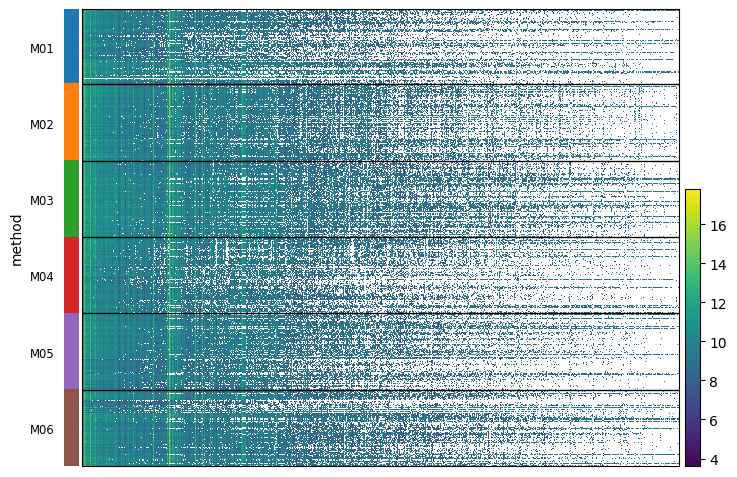

In [32]:
adata = utils.sort_anndata_by_missingness(adata)

sc.pl.heatmap(adata, var_names=adata.var_names, groupby="method", show_gene_labels=False)

In [15]:
protein_missingness = utils.get_missingness_per_protein(adata, layer="raw")
print(f"Proteins with no missing values: {np.sum(protein_missingness == 0) / len(protein_missingness) * 100:.2f}%")

Proteins with no missing values: 0.00%


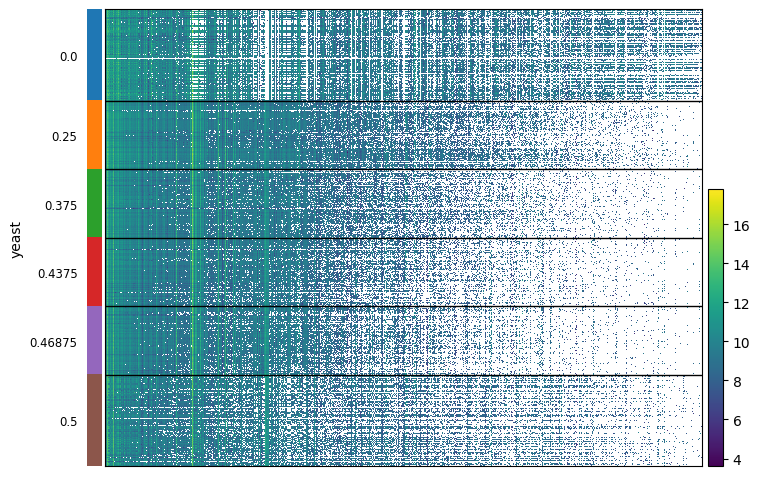

In [33]:
sc.pl.heatmap(adata, var_names=adata.var_names, groupby="yeast", show_gene_labels=False)

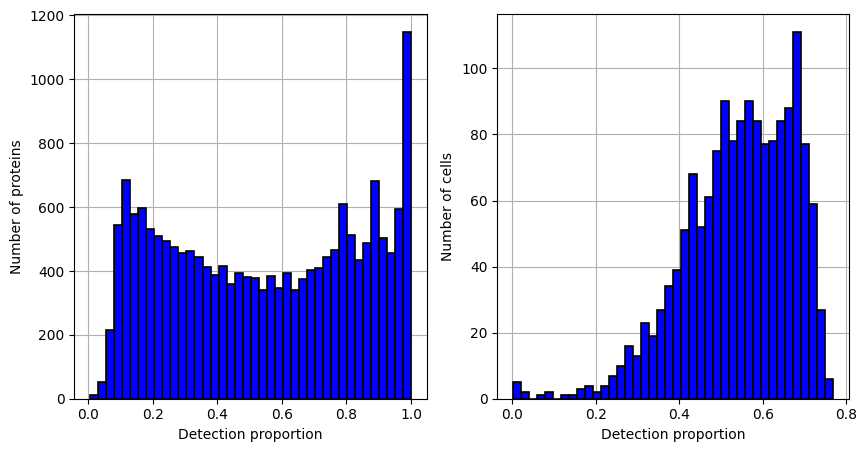

In [34]:
mask = np.isnan(adata.X)

p_protein = (~mask).mean(axis=0)
p_cell = (~mask).mean(axis=1)

fig, axes = plt.subplots(1, 2, figsize=(10, 5))

ax = axes[0]
ax.hist(p_protein, bins=40, edgecolor="black", linewidth=1.2, color="blue")
ax.set_xlabel("Detection proportion")
ax.set_ylabel("Number of proteins")
ax.grid(True)
ax.set_axisbelow(True)

ax = axes[1]
ax.hist(p_cell, bins=40, edgecolor="black", linewidth=1.2, color="blue")
ax.set_xlabel("Detection proportion")
ax.set_ylabel("Number of cells")
ax.grid(True)
ax.set_axisbelow(True)

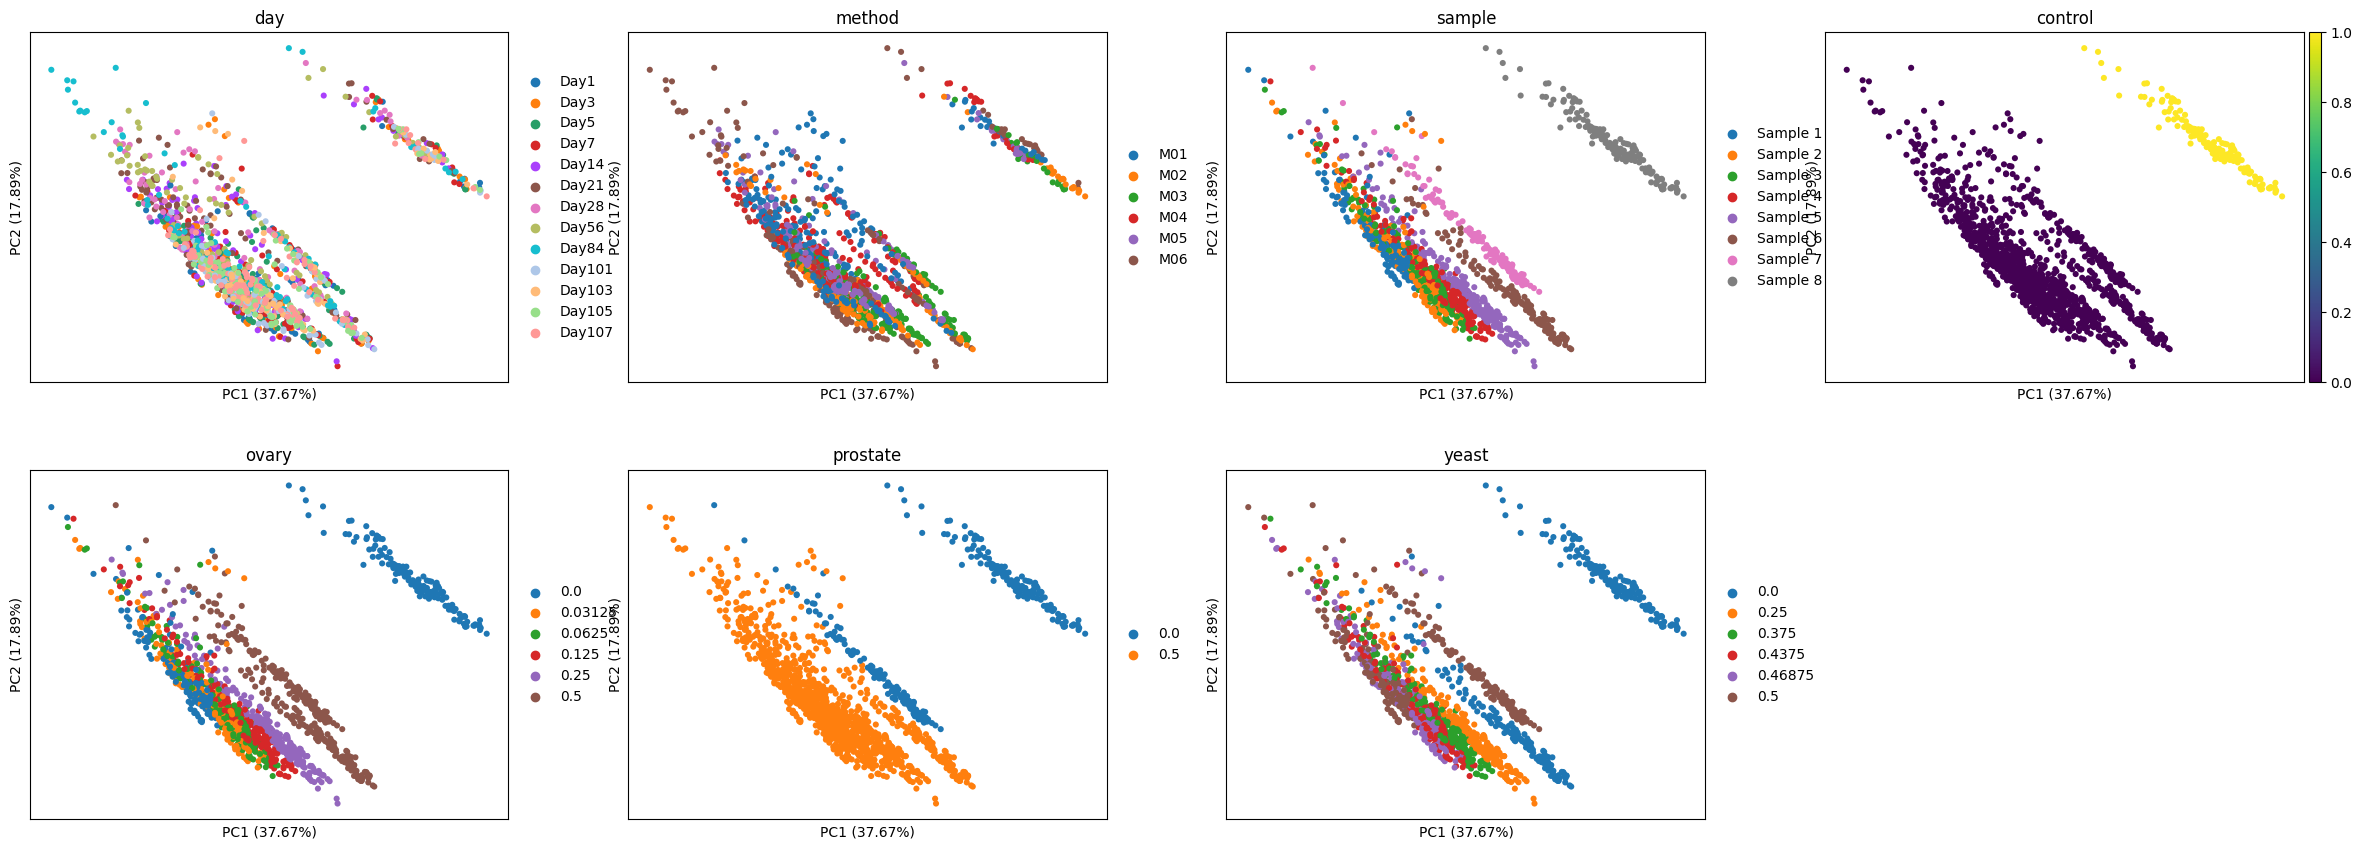

2023-12-05 01:04:28.060143: E tensorflow/compiler/xla/stream_executor/cuda/cuda_dnn.cc:9342] Unable to register cuDNN factory: Attempting to register factory for plugin cuDNN when one has already been registered
2023-12-05 01:04:28.060225: E tensorflow/compiler/xla/stream_executor/cuda/cuda_fft.cc:609] Unable to register cuFFT factory: Attempting to register factory for plugin cuFFT when one has already been registered
2023-12-05 01:04:28.061305: E tensorflow/compiler/xla/stream_executor/cuda/cuda_blas.cc:1518] Unable to register cuBLAS factory: Attempting to register factory for plugin cuBLAS when one has already been registered
2023-12-05 01:04:30.335373: W tensorflow/compiler/tf2tensorrt/utils/py_utils.cc:38] TF-TRT Warning: Could not find TensorRT


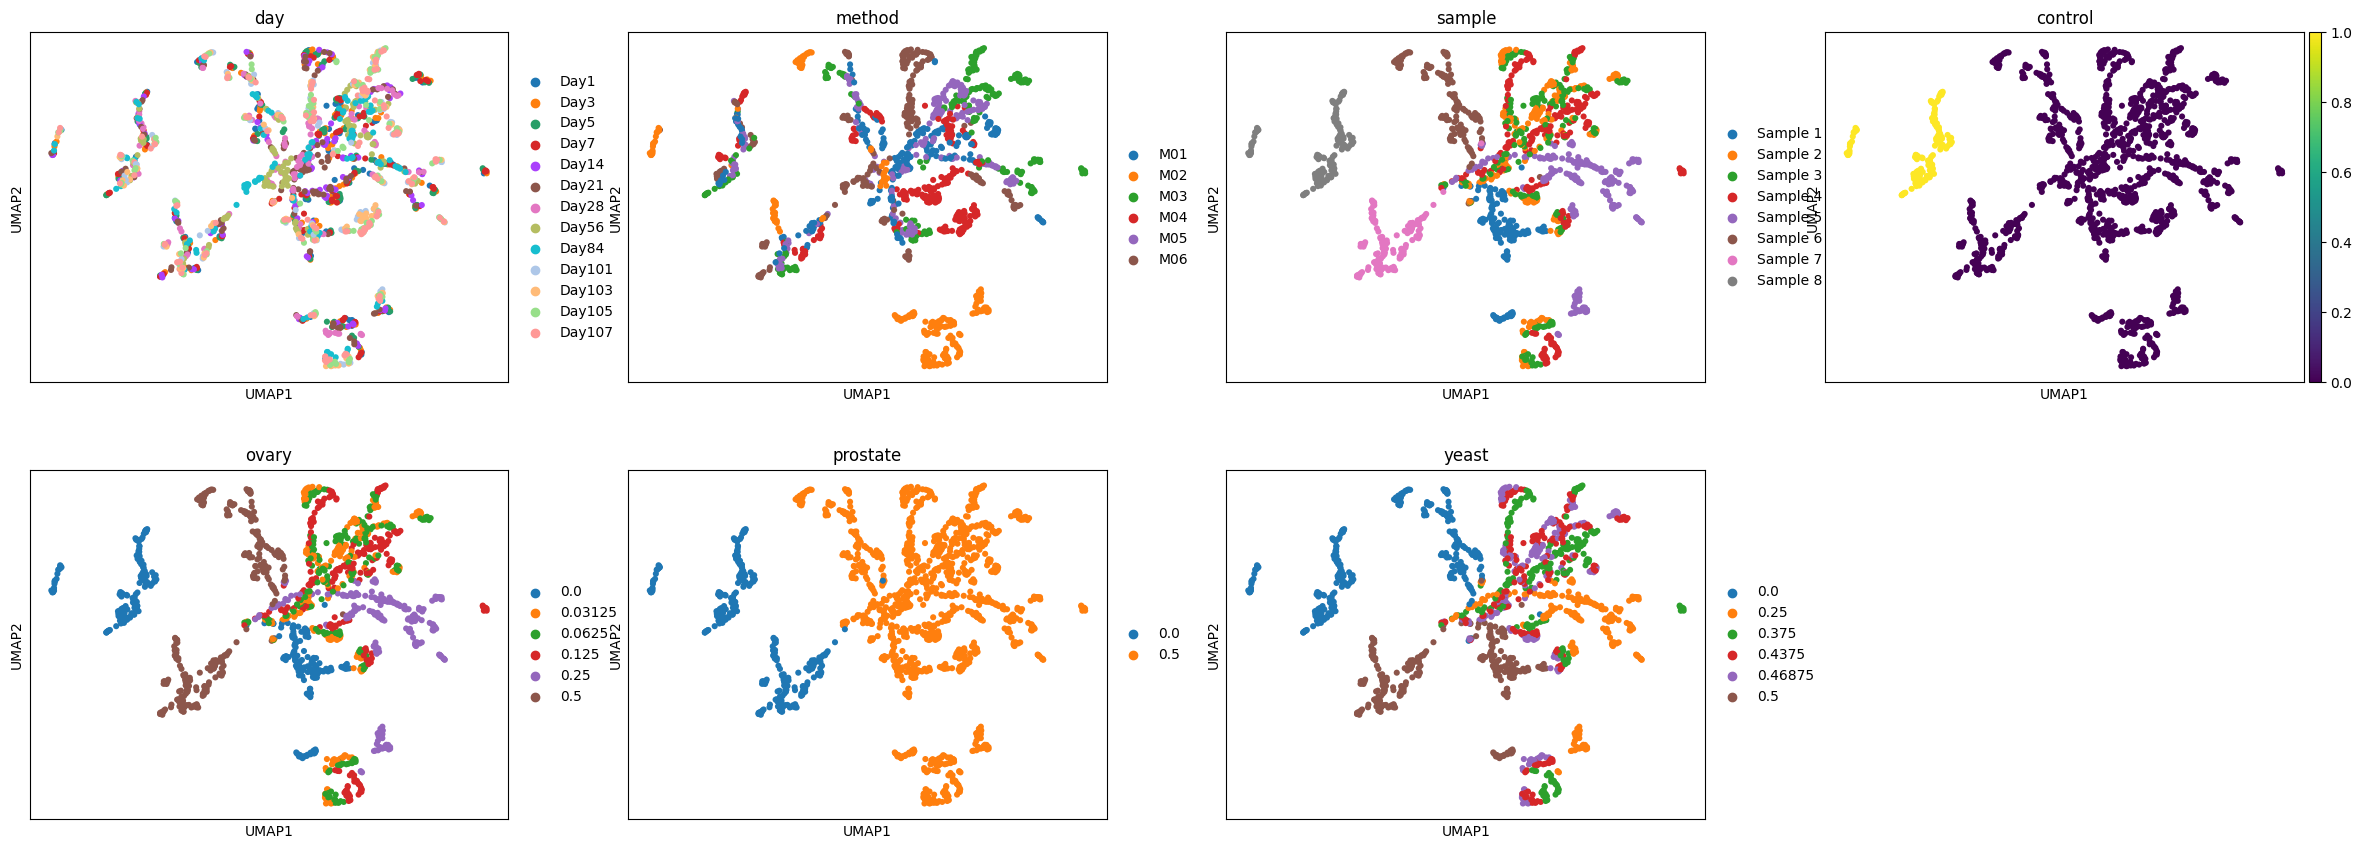

In [35]:
adata.X = bm.impute_downshifted_normal_sample(adata, layer="raw")

sc.tl.pca(adata, n_comps=16)# remove control cells


sc.pl.pca(
    adata,
    annotate_var_explained=True,
    color=["day", "method", "sample", "control", "ovary", "prostate", "yeast"],
    components=["1,2"],
)

sc.pp.neighbors(adata, n_neighbors=10, n_pcs=16)
sc.tl.umap(adata)
sc.pl.umap(
    adata,
    color=["day", "method", "sample", "control", "ovary", "prostate", "yeast"],
)

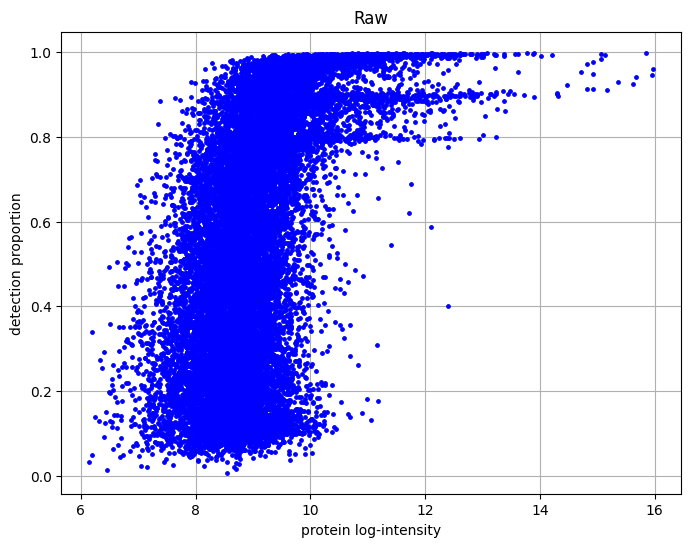

In [17]:
pl.scatter_protein_detection_proportion_and_intensity(adata.layers["raw"], title="Raw")

/home/rasmus/sollertis/school/s11/thesis/MS_mv_modelling/scp/plots.py:83: RuntimeWarning: Mean of empty slice
  x_obs_protein = np.nanmean(x, axis=0)


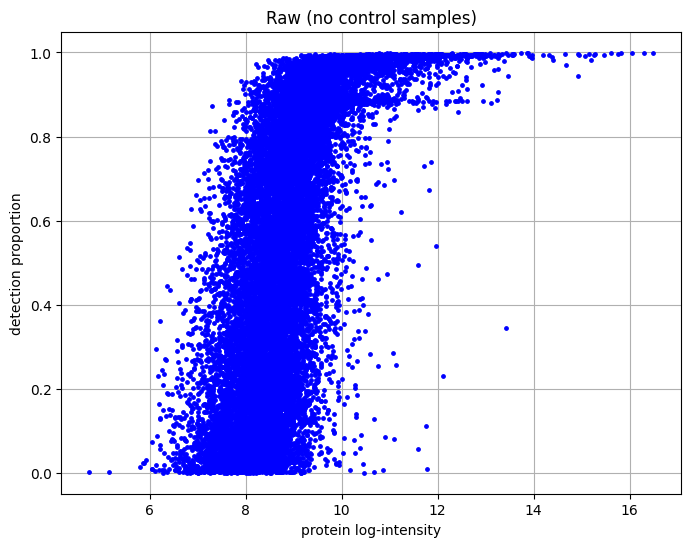

In [18]:
pl.scatter_protein_detection_proportion_and_intensity(adata.layers["raw"][adata.obs["control"] == 0,], title="Raw (no control samples)")